# 05 Deep Learning Modelling

Importing libraries.

In [1]:
import pandas as pd
import numpy as np

import yaml

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint 

Reading files.

In [2]:
try:
    with open('../params.yml','r') as file:
        config = yaml.safe_load(file)  
except Exception as e:
    print('Error reading the config file')

In [3]:
config

{'raw_data_1': '../01_data/PDB_31-07-2011.csv',
 'raw_data_2': '../01_data/PDB_31-12-2012.csv',
 'data': '../01_data/data.csv',
 'new_data': '../01_data/new_data.csv',
 'xy': '../01_data/xy.csv',
 'xy_06': '../01_data/xy_06.csv',
 'xy_enc': '../01_data/xy_enc.csv'}

In [4]:
xy = pd.read_csv(config['xy_enc'])[:50000]

In [5]:
x = xy.iloc[:,0:100]

### Enconding y

In [6]:
from sklearn.preprocessing import OneHotEncoder

encoder= OneHotEncoder().fit(xy[['y3']])

y_enc = encoder.transform(xy[['y3']]).toarray()
y_enc

#y_enc_df = pd.DataFrame(y_enc, columns = encoder.get_feature_names_out())

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [7]:
# Split the training and test data.
from sklearn.model_selection import train_test_split

np.random.seed(10)      #fix the random number generator, useful if you are including different columns
x_train, x_test, y_train, y_test = train_test_split(x,y_enc, test_size=0.3, random_state=42)

In [8]:
x_train.shape

(35000, 100)

In [9]:
y_train.shape

(35000, 3)

In [ ]:
%run functions.py

### Adding layers

In [14]:
model = keras.Sequential()

model.add(Dense(units = 3000, activation='relu', input_shape=(100,) ))
model.add(Dense(units = 1500, activation='relu', input_shape=(100,) ))
model.add(Dense(units = 900, activation='relu', input_shape=(100,) ))
model.add(Dense(units = 450, activation='relu', input_shape=(100,) ))
model.add(Dense(units = 3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

history = model.fit(
    x_train, y_train, 
    epochs=100, 
    batch_size=32, verbose=0)

### Plotting accuracy

In [1]:
%%writefile -a functions.py

import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1] #'acc'
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

Appending to functions.py


<Figure size 800x600 with 0 Axes>

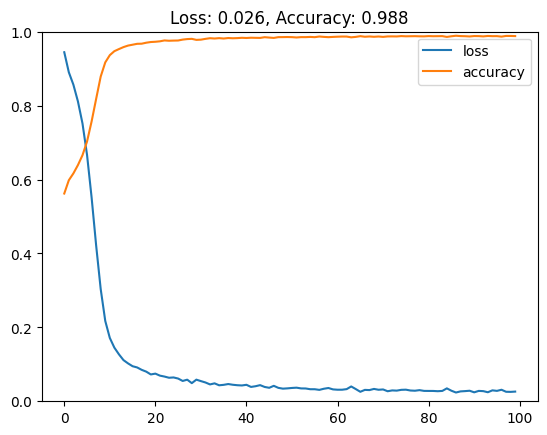

In [15]:
plot_loss_accuracy(history)

### Scoring the model

In [2]:
%%writefile -a functions.py

from sklearn.metrics import cohen_kappa_score, classification_report 

def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

Appending to functions.py


In [20]:
y_train_tr = [0 if str(x)=='[0. 0. 1.]' else(1 if str(x)=='[1. 0. 0.]' else 2) for x in y_train]

In [21]:
y_test_tr = [0 if str(x)=='[0. 0. 1.]' else(1 if str(x)=='[1. 0. 0.]' else 2) for x in y_test]

In [22]:
y_pred_tr = np.argmax(model.predict(x_train), axis=1).reshape(-1,1)

y_pred_te = np.argmax(model.predict(x_test), axis=1).reshape(-1,1)

469/469 [==============================] - 10s 21ms/step


In [23]:
model_performance_class(y_train_tr, y_pred_tr, y_test_tr, y_pred_te)

Results obtained for the TRAIN SET
The Cohen's Kappa is: -0.48
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12545
           1       0.00      0.00      0.00     14137
           2       0.00      0.00      0.00      8318

    accuracy                           0.00     35000
   macro avg       0.00      0.00      0.00     35000
weighted avg       0.00      0.00      0.00     35000

Results obtained for the TEST SET
The Cohen's Kappa is: -0.12
              precision    recall  f1-score   support

           0       0.24      0.24      0.24      5565
           1       0.30      0.17      0.22      5918
           2       0.20      0.35      0.26      3517

    accuracy                           0.24     15000
   macro avg       0.25      0.26      0.24     15000
weighted avg       0.26      0.24      0.24     15000

